In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib

In [ ]:
data = pd.read_csv('/content/clean_disease_data.csv')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from imblearn.over_sampling import SMOTE

# Step 1: Load and preprocess the dataset
file_path = '/content/clean_disease_data.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Ensure the target variable 'class' is set to 1 for all values greater than 1, and 0 otherwise
data['class'] = data['class'].apply(lambda x: 1 if x > 1 else 0)

# Convert the 'class' column to a categorical type
data['class'] = data['class'].astype('category')

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop('class', axis=1))
data_scaled = pd.DataFrame(data_scaled, columns=data.columns[:-1])

# Save the updated dataset
updated_file_path = 'updated_cleaned_data_heart.csv'
data.to_csv(updated_file_path, index=False)

# Display the first few rows of the updated dataset
print(data.head())

# Step 2: Apply SMOTE for oversampling
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(data_scaled, data['class'])

# Combine resampled features and labels
data_resampled = pd.DataFrame(X_resampled, columns=data.columns[:-1])
data_resampled['class'] = y_resampled


# Convert 'class' column back to numeric type before adding noise
data_resampled['class'] = data_resampled['class'].astype(int)


# Add random noise to ensure wider coverage
noise = np.random.normal(0, 0.1, data_resampled.shape)
data_noisy = data_resampled + noise

# Clip the values to ensure they stay within the valid range
data_noisy = data_noisy.clip(lower=data_scaled.min().min(), upper=data_scaled.max().max(), axis=0)

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal class  
0  0.0   6.0     0  
1  3.0   3.0     1  
2  2.0   7.0     0  
3  0.0   3.0     0  
4  0.0   3.0     0  


In [ ]:
#WGAN-GP
from torch.autograd import grad
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from torch.autograd import grad

# Load and normalize the dataset
file_path = '/content/updated_cleaned_data_heart.csv' # Replace with your actual file path
data = pd.read_csv(file_path)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.values)

class HeartDiseaseDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return torch.tensor(self.data[idx], dtype=torch.float32)

dataset = HeartDiseaseDataset(data_scaled)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class Generator(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(input_dim, 128),
      nn.ReLU(),
      nn.Linear(128, 256),
      nn.ReLU(),
      nn.Linear(256, output_dim),
      nn.Tanh()
    )

  def forward(self, x):
    return self.model(x)

class Discriminator(nn.Module):
  def __init__(self, input_dim):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(input_dim, 256),
      nn.LeakyReLU(0.2),
      nn.Linear(256, 128),
      nn.LeakyReLU(0.2),
      nn.Linear(128, 1)
    )

  def forward(self, x):
    return self.model(x)

def gradient_penalty(discriminator, real_data, fake_data):
  batch_size = real_data.size(0)
  epsilon = torch.rand(batch_size, 1) # Remove the extra dimension here
  epsilon = epsilon.expand_as(real_data)

  interpolation = epsilon * real_data + (1 - epsilon) * fake_data
  interpolation.requires_grad_(True)

  interpolation_output = discriminator(interpolation)
  gradients = torch.autograd.grad(
    outputs=interpolation_output,
    inputs=interpolation,
    grad_outputs=torch.ones(interpolation_output.size()),
    create_graph=True,
    retain_graph=True
  )[0]

  gradients = gradients.view(batch_size, -1)
  gradient_norm = gradients.norm(2, dim=1)
  gradient_penalty = ((gradient_norm - 1) ** 2).mean()
  return gradient_penalty

input_dim = data_noisy.shape[1]
latent_dim = 100

generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 10000
lambda_gp = 10

for epoch in range(num_epochs):
  for i, real_data in enumerate(dataloader):
    batch_size = real_data.size(0)

    # Train Discriminator
    optimizer_d.zero_grad()

    noise = torch.randn(batch_size, latent_dim)
    fake_data = generator(noise)

    output_real = discriminator(real_data)
    output_fake = discriminator(fake_data.detach())

    loss_d_real = -output_real.mean()
    loss_d_fake = output_fake.mean()

    gp = gradient_penalty(discriminator, real_data, fake_data)
    loss_d = loss_d_real + loss_d_fake + lambda_gp * gp

    loss_d.backward(retain_graph=True) # Retain the graph for the generator update
    optimizer_d.step()

    # Train Generator
    if i % 5 == 0: # Update generator less frequently
      optimizer_g.zero_grad()

      output_fake = discriminator(fake_data)
      loss_g = -output_fake.mean()

      loss_g.backward()

      optimizer_g.step()

  if epoch % 500 == 0:
    print(f'Epoch [{epoch}/{num_epochs}] Loss D: {loss_d.item()}, Loss G: {loss_g.item()}')

print("Training complete!")

def generate_data(generator, num_samples, latent_dim):
  noise = torch.randn(num_samples, latent_dim)
  generated_data = generator(noise)
  return generated_data.detach().numpy()

num_samples_to_generate = 1000
generated_samples = generate_data(generator, num_samples_to_generate, latent_dim)
generated_samples_rescaled = scaler.inverse_transform(generated_samples)

augmented_data = pd.DataFrame(generated_samples_rescaled, columns=data.columns)
augmented_data.to_csv('aug_heart_disease_data.csv', index=False)

# Display the first few rows of the augmented dataset
print(augmented_data.head())


Epoch [0/10000] Loss D: 5.804615497589111, Loss G: 0.08379705995321274
Epoch [500/10000] Loss D: -1.067384958267212, Loss G: -1.7873119115829468
Epoch [1000/10000] Loss D: -1.3567211627960205, Loss G: -1.4710147380828857
Epoch [1500/10000] Loss D: -1.7306501865386963, Loss G: -1.2441508769989014
Epoch [2000/10000] Loss D: -1.5560126304626465, Loss G: -0.5557035207748413
Epoch [2500/10000] Loss D: -1.5511298179626465, Loss G: -0.32370615005493164
Epoch [3000/10000] Loss D: -1.718953251838684, Loss G: -0.22237901389598846
Epoch [3500/10000] Loss D: -1.4173533916473389, Loss G: 0.07595987617969513
Epoch [4000/10000] Loss D: -1.4022372961044312, Loss G: -0.1325438916683197
Epoch [4500/10000] Loss D: -1.9142309427261353, Loss G: -0.47056078910827637
Epoch [5000/10000] Loss D: -1.4422719478607178, Loss G: -0.5730657577514648
Epoch [5500/10000] Loss D: -1.7131999731063843, Loss G: -0.5982556939125061
Epoch [6000/10000] Loss D: -1.3012679815292358, Loss G: -0.5110317468643188
Epoch [6500/10000

**Validation Steps for Generated Data**

In [ ]:
import pandas as pd

# Load the actual and augmented datasets
actual_data_path = '/content/updated_cleaned_data_heart.csv'
augmented_data_path = '/content/aug_heart_disease_data.csv'

actual_data = pd.read_csv(actual_data_path)
augmented_data = pd.read_csv(augmented_data_path)

# Display the first few rows of both datasets
actual_data_head = actual_data.head()
augmented_data_head = augmented_data.head()

actual_data_head, augmented_data_head


(   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
 0   63    1   1       145   233    1        2      150      0      2.3      3   
 1   67    1   4       160   286    0        2      108      1      1.5      2   
 2   67    1   4       120   229    0        2      129      1      2.6      2   
 3   37    1   3       130   250    0        0      187      0      3.5      3   
 4   41    0   2       130   204    0        2      172      0      1.4      1   
 
     ca  thal  class  
 0  0.0   6.0      0  
 1  3.0   3.0      1  
 2  2.0   7.0      0  
 3  0.0   3.0      0  
 4  0.0   3.0      0  ,
          age       sex        cp    trestbps       chol       fbs   restecg  \
 0  49.282160  1.146395  4.112608  114.840675  275.00397  0.008642  0.055581   
 1  62.277880  1.061718  4.097564  144.100890  298.28336 -0.051110  1.983427   
 2  56.015316  1.139419  3.154888  136.468540  250.98117 -0.058401  1.983416   
 3  56.242508  1.146083  4.058071  138.170200  

Statistical Comparison:

In [ ]:
print("Actual Data Statistics:\n", actual_data.describe())
print("Augmented Data Statistics:\n", augmented_data.describe())


Actual Data Statistics:
               age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
std      9.038662    0.467299    0.960126   17.599748   51.776918    0.356198   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  241.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  275.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.990099  149.607261    0.326733    1.039604    1.600660    0.663366   
st

Visual Comparison:

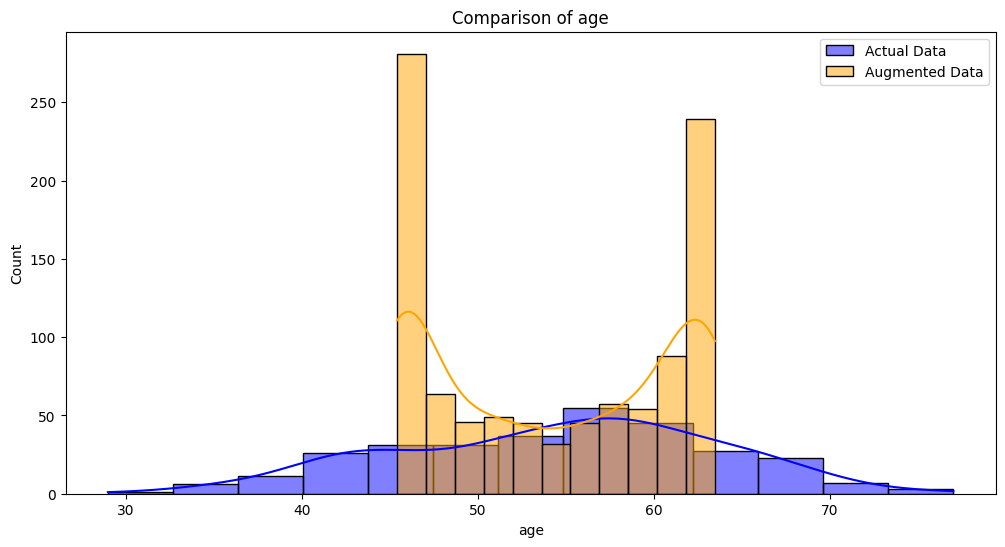

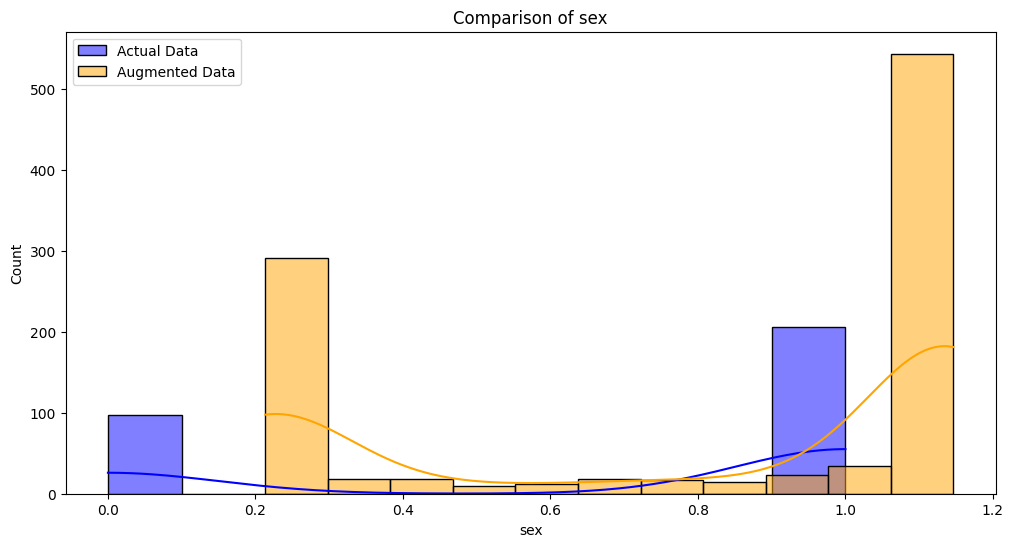

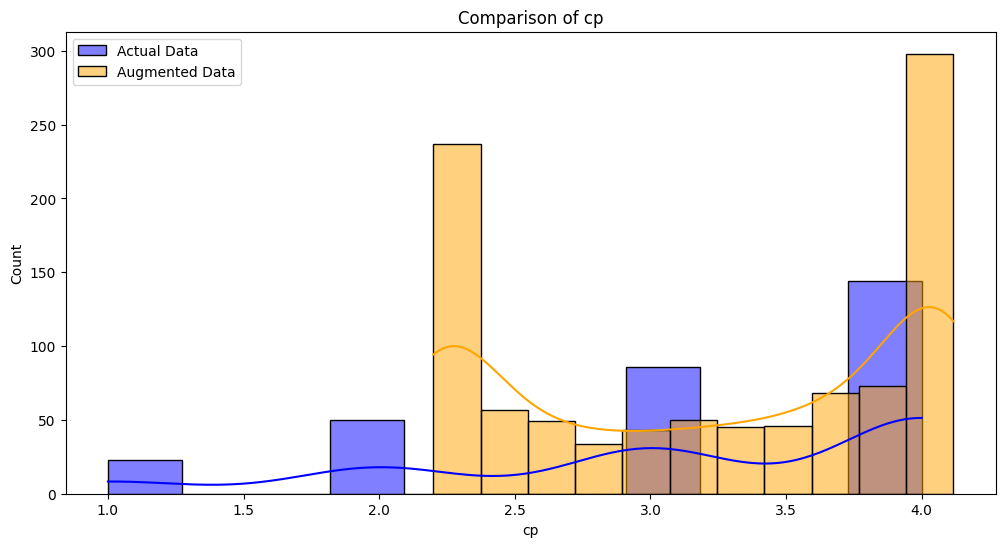

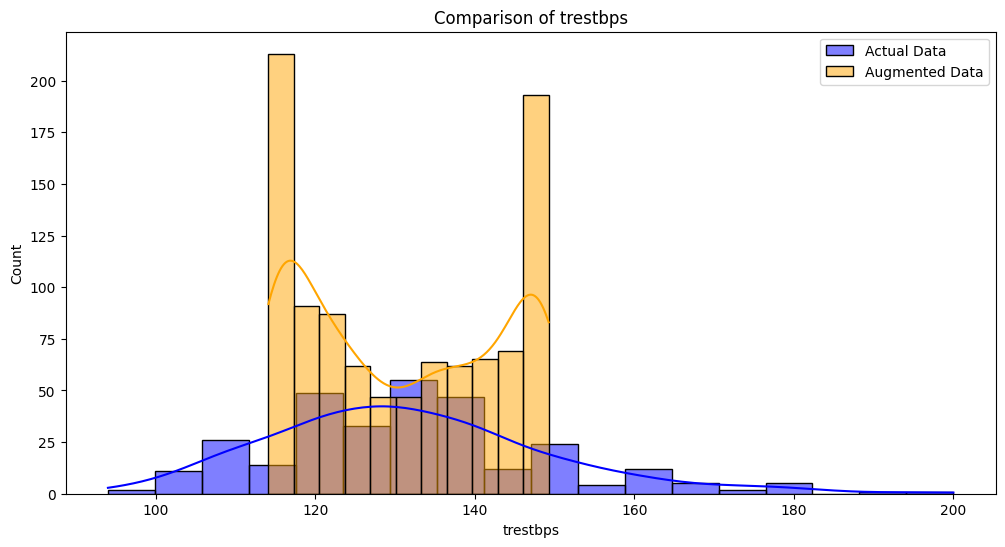

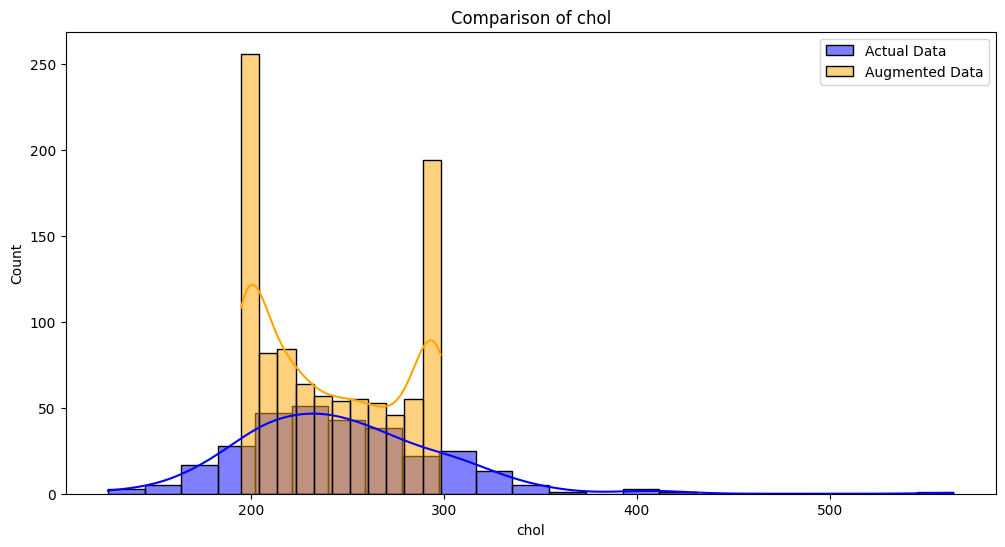

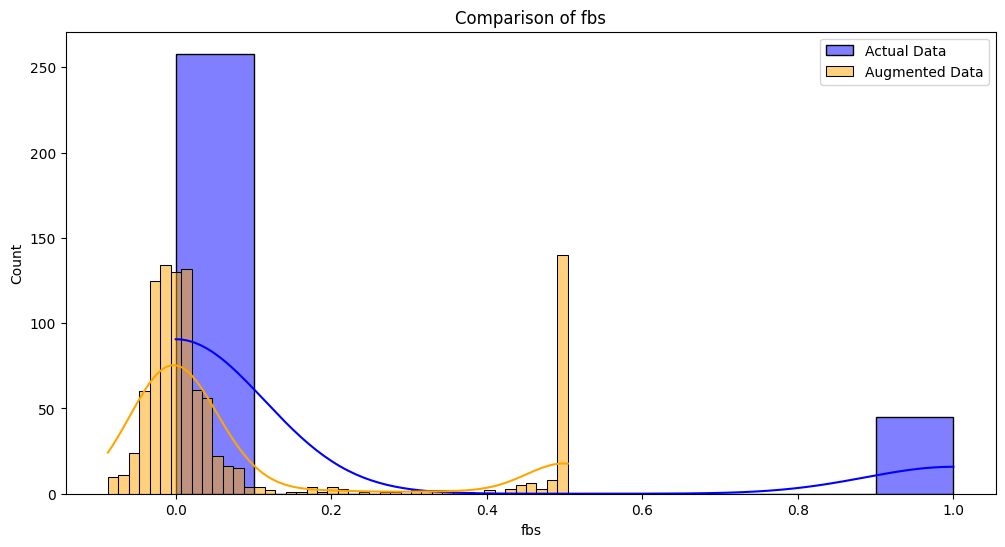

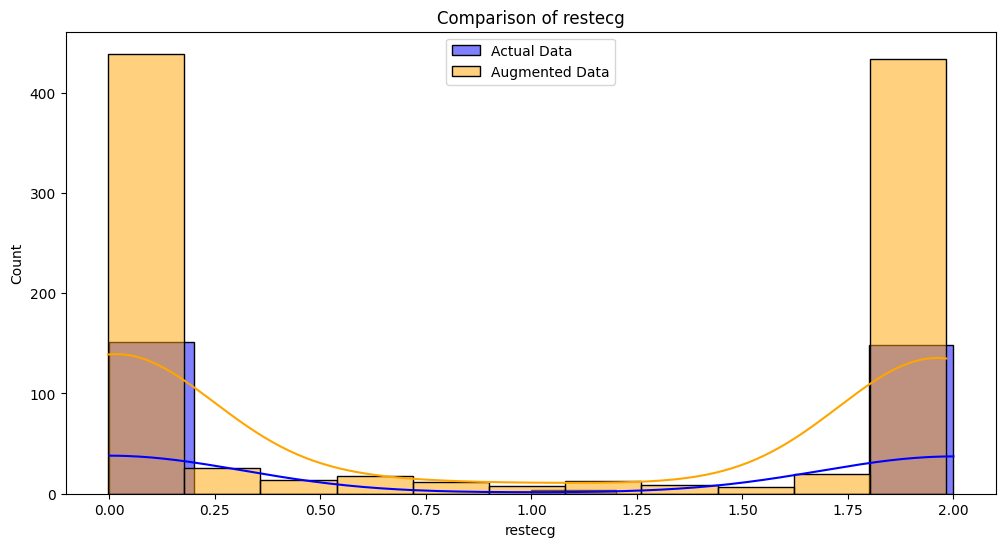

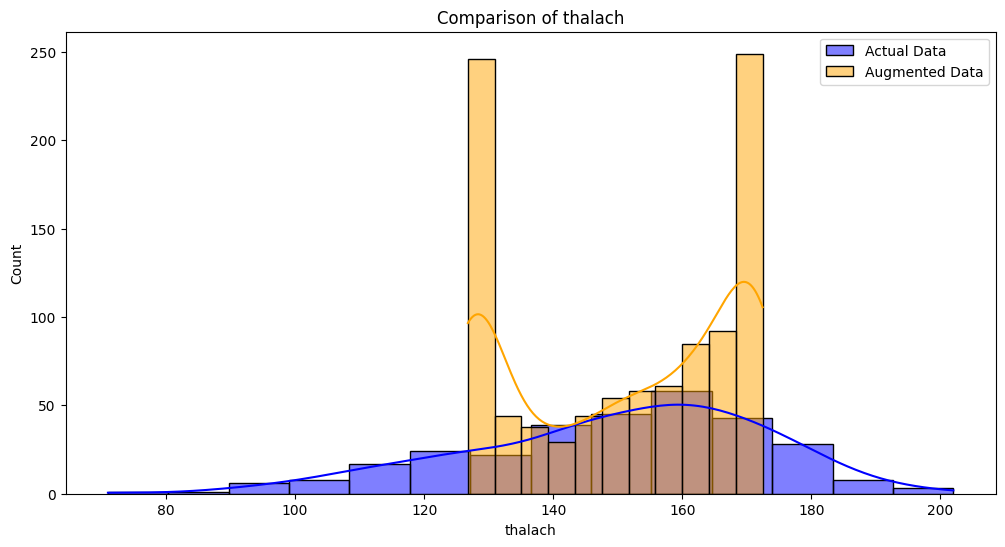

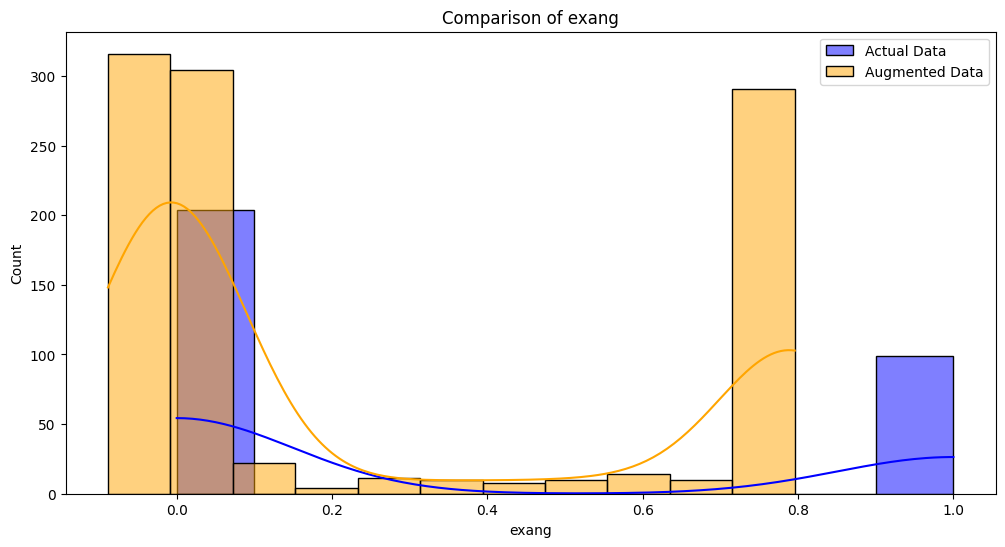

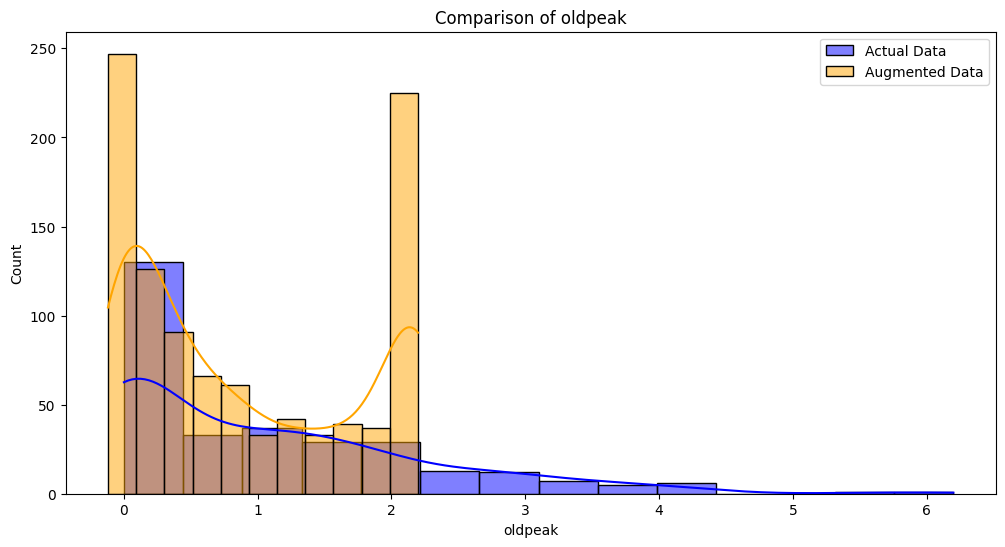

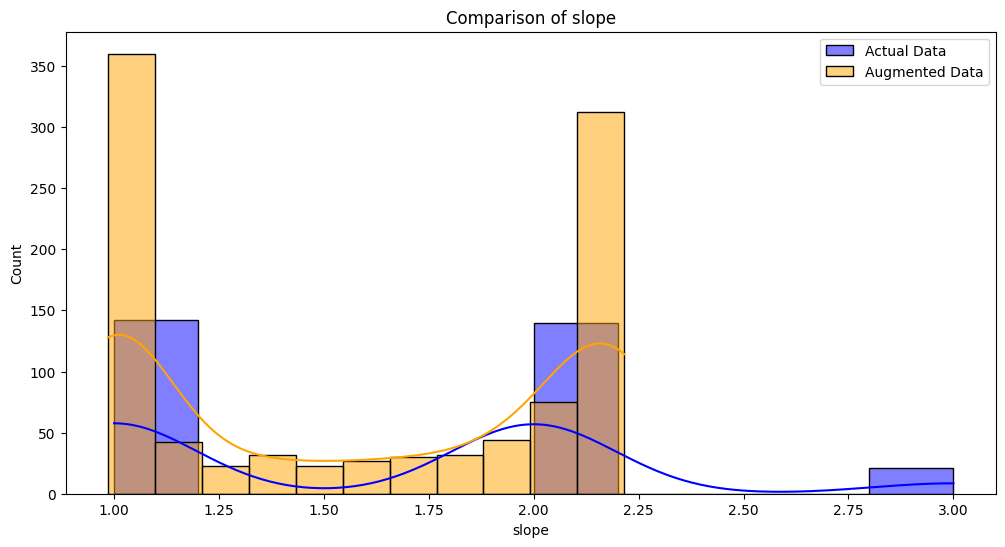

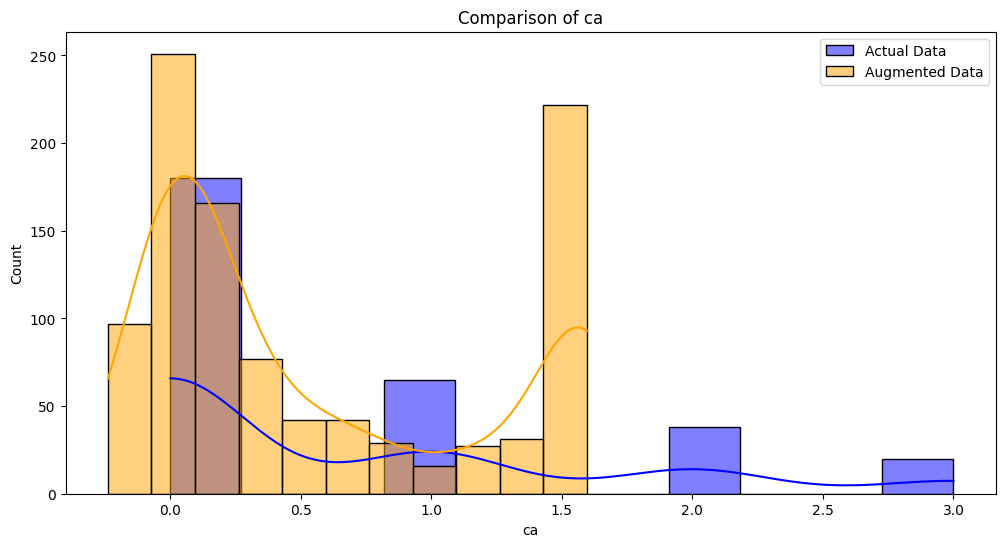

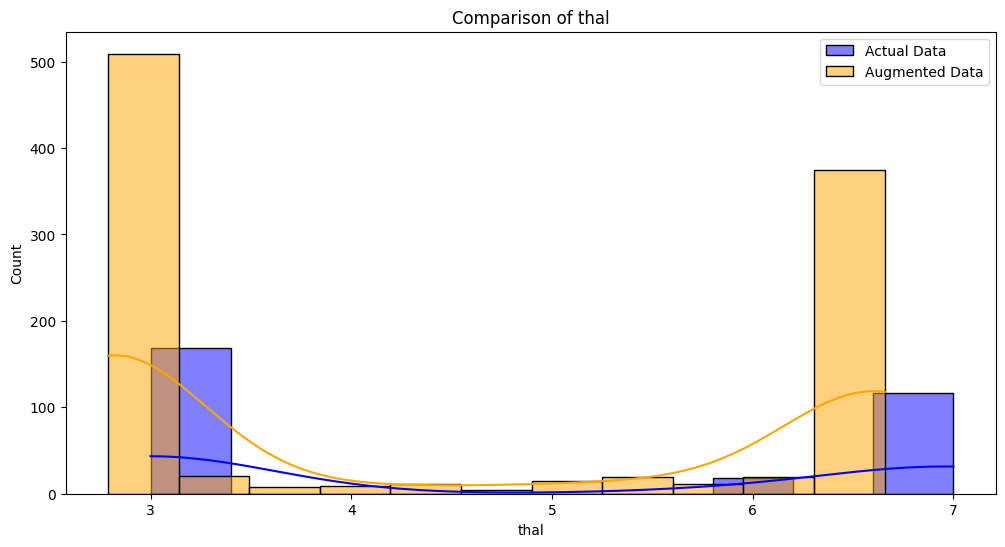

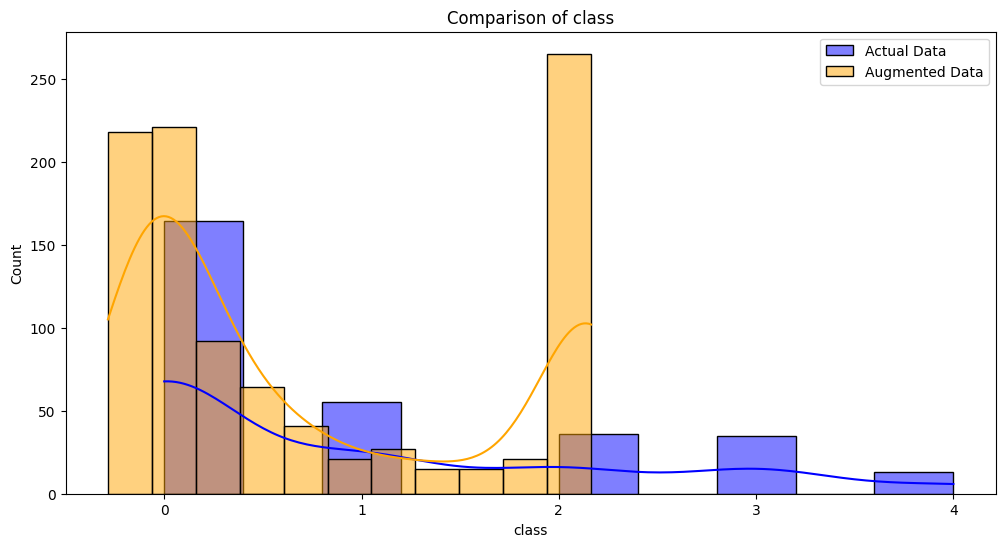

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to compare
columns = actual_data.columns

for column in columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(actual_data[column], label='Actual Data', kde=True, color='blue')
    sns.histplot(augmented_data[column], label='Augmented Data', kde=True, color='orange')
    plt.title(f'Comparison of {column}')
    plt.legend()
    plt.show()


Dimensionality Reduction and Visualization:

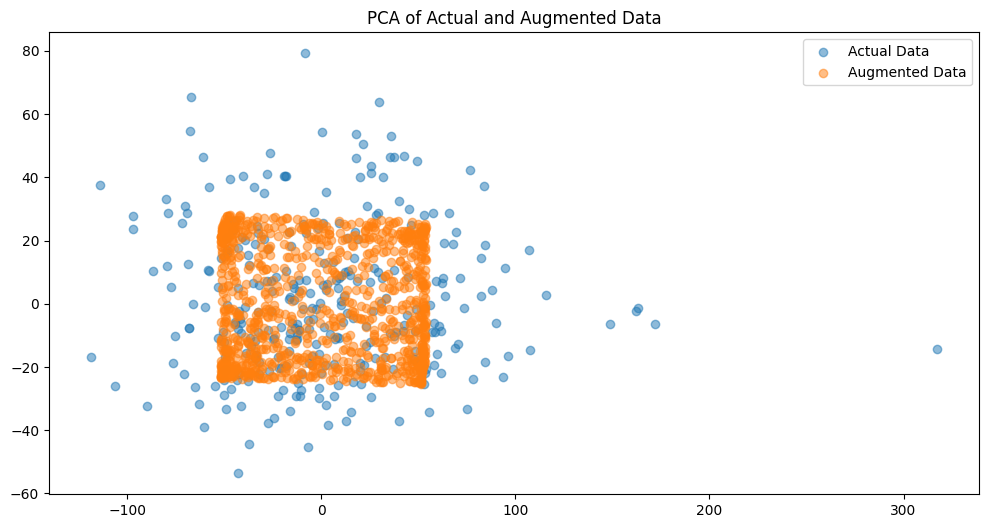

In [ ]:
import matplotlib.pyplot as plt # Import the matplotlib.pyplot module
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)
combined_data = np.vstack((actual_data, augmented_data))
pca_result = pca.fit_transform(combined_data)

plt.figure(figsize=(12, 6))
plt.scatter(pca_result[:len(actual_data), 0], pca_result[:len(actual_data), 1], label='Actual Data', alpha=0.5)
plt.scatter(pca_result[len(actual_data):, 0], pca_result[len(actual_data):, 1], label='Augmented Data', alpha=0.5)
plt.title('PCA of Actual and Augmented Data')
plt.legend()
plt.show()


**Cluster Analysis**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


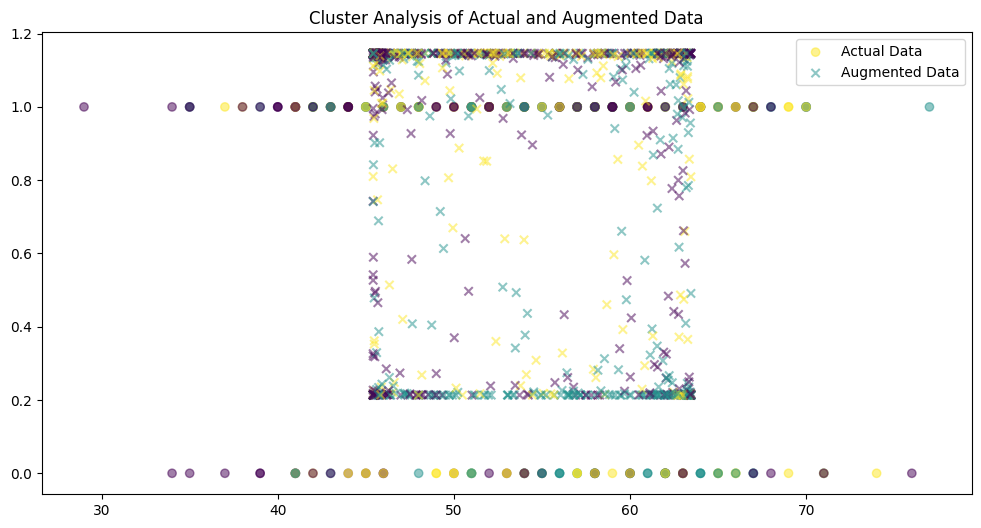

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

combined_data = pd.concat([actual_data, augmented_data])
kmeans = KMeans(n_clusters=3)
kmeans.fit(combined_data)

actual_data['Cluster'] = kmeans.predict(actual_data)
augmented_data['Cluster'] = kmeans.predict(augmented_data)

plt.figure(figsize=(12, 6))
plt.scatter(actual_data.iloc[:, 0], actual_data.iloc[:, 1], c=actual_data['Cluster'], label='Actual Data', alpha=0.5)
plt.scatter(augmented_data.iloc[:, 0], augmented_data.iloc[:, 1], c=augmented_data['Cluster'], label='Augmented Data', alpha=0.5, marker='x')
plt.title('Cluster Analysis of Actual and Augmented Data')
plt.legend()
plt.show()


Feature Correlation:

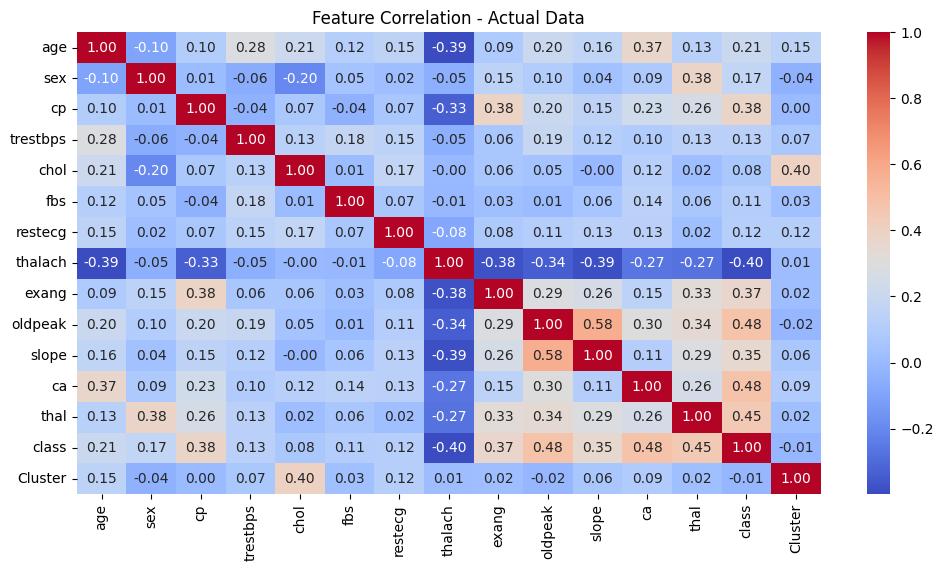

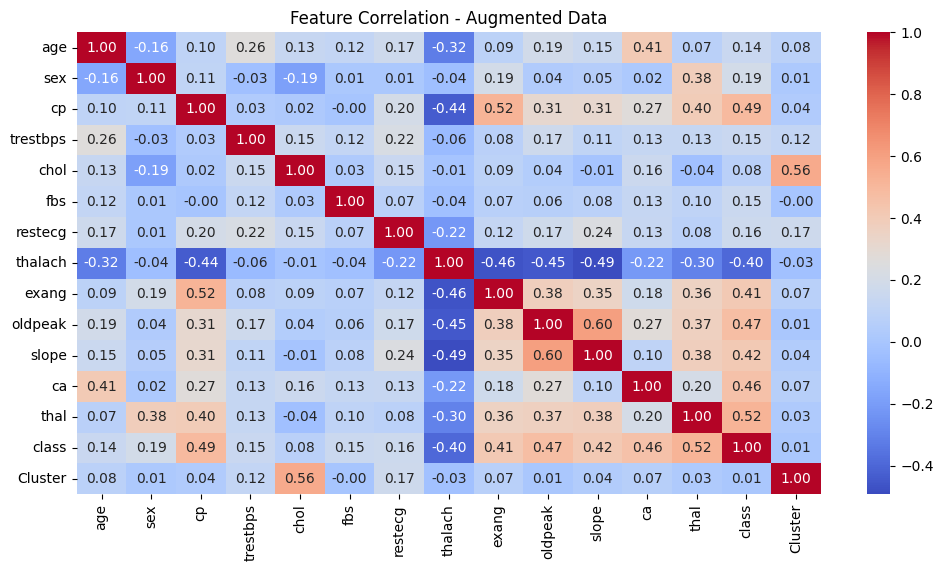

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(actual_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation - Actual Data')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(augmented_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation - Augmented Data')
plt.show()


Machine Learning Model Evaluation:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming the last column is the target variable
X_actual = actual_data.iloc[:, :-1]
y_actual = actual_data.iloc[:, -1]
X_augmented = augmented_data.iloc[:, :-1]
y_augmented = augmented_data.iloc[:, -1]

# Convert y_augmented to discrete values if it's continuous
# Assuming it needs to be rounded to the nearest integer
y_augmented = y_augmented.round().astype(int)  # Round and convert to integers

X_train, X_test, y_train, y_test = train_test_split(X_actual, y_actual, test_size=0.3, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate on actual test set
y_pred_actual = model.predict(X_test)
print("Accuracy on actual test set:", accuracy_score(y_test, y_pred_actual))

# Evaluate on augmented data
y_pred_augmented = model.predict(X_augmented)
print("Accuracy on augmented data:", accuracy_score(y_augmented, y_pred_augmented))

Accuracy on actual test set: 0.978021978021978
Accuracy on augmented data: 0.993


# Convert the 'class' column to a categorical type


In [ ]:
data = pd.read_csv('/content/aug_heart_disease_data.csv')
data['class'] = data['class'].astype('category')

In [ ]:
data.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
995,61.221350,1.146388,3.997277,119.715996,286.81607,0.027717,0.833384,127.734480,0.787416,2.149452,2.062047,0.934150,6.657954,0.724858
996,45.429134,1.146394,2.225203,119.828180,298.02050,-0.026895,-0.003228,172.383650,-0.140845,0.133199,1.027472,-0.106837,3.638200,-0.015518
997,50.193756,1.145997,2.358916,118.827610,290.90836,-0.005034,-0.003229,166.026260,-0.138736,0.513159,0.985995,0.036475,2.864644,0.005649
998,47.991657,0.213341,2.262644,137.937530,269.83234,0.004257,1.983100,172.237170,-0.142286,0.976797,2.001905,0.105839,2.787591,0.045102
999,60.957306,1.146395,3.990687,148.524140,226.88269,-0.020890,1.983427,126.770035,0.795751,2.137610,2.085521,1.516111,2.789371,0.724858


Reverting augmented data target lables to original class distributions

In [ ]:
import pandas as pd
import numpy as np

# Load the original dataset to get the original class distribution
original_data_path = '/content/clean_disease_data.csv'
original_data = pd.read_csv(original_data_path)

# Load the synthetic dataset
synthetic_data_path = '/content/aug_heart_disease_data.csv'
synthetic_data = pd.read_csv(synthetic_data_path)

# Display class distribution in the original dataset
class_distribution = original_data['class'].value_counts(normalize=True)
print("Original class distribution:")
print(class_distribution)

# Function to sample class labels based on the original distribution
def sample_class_labels(size, distribution):
    classes = distribution.index.tolist()
    probabilities = distribution.values
    return np.random.choice(classes, size=size, p=probabilities)

# Apply the function to the synthetic data
synthetic_data['class'] = sample_class_labels(len(synthetic_data), class_distribution)

# Save the updated synthetic dataset with reverted class labels
updated_synthetic_data_path = 'updated_augmented_heart_disease_data.csv'
synthetic_data.to_csv(updated_synthetic_data_path, index=False)

# Display the first few rows of the updated synthetic dataset
print(synthetic_data.head())


Original class distribution:
class
0    0.541254
1    0.181518
2    0.118812
3    0.115512
4    0.042904
Name: proportion, dtype: float64
         age       sex        cp    trestbps       chol       fbs   restecg  \
0  49.282160  1.146395  4.112608  114.840675  275.00397  0.008642  0.055581   
1  62.277880  1.061718  4.097564  144.100890  298.28336 -0.051110  1.983427   
2  56.015316  1.139419  3.154888  136.468540  250.98117 -0.058401  1.983416   
3  56.242508  1.146083  4.058071  138.170200  247.48671 -0.005290  1.967130   
4  45.642860  1.048243  2.316776  129.850720  195.42060  0.007852  1.967308   

     thalach     exang   oldpeak     slope        ca      thal  class  
0  129.95454  0.794688  1.310464  1.246573  1.596195  6.595049      1  
1  163.46115 -0.142282  0.777332  2.197166  0.156523  6.339523      3  
2  140.89078 -0.142286  0.885974  2.065155  1.592861  6.327324      0  
3  126.97007 -0.137169  2.198679  2.097974  1.530340  6.602425      2  
4  172.11064  0.551097  0.0

Combining the two datasets

In [ ]:
import pandas as pd

original_data_path = '/content/clean_disease_data.csv'
synthetic_data_path = '/content/updated_augmented_heart_disease_data.csv'

# Load the data from the CSV files into DataFrames
original_data = pd.read_csv(original_data_path)
synthetic_data = pd.read_csv(synthetic_data_path)

# Combine the original and synthetic datasets
combined_data = pd.concat([original_data, synthetic_data], ignore_index=True)

# Save the combined dataset
combined_data_path = 'improved_heart_disease_data.csv'
combined_data.to_csv(combined_data_path, index=False)

In [ ]:
data = pd.read_csv('/content/improved_heart_disease_data.csv')
data['class'] = data['class'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1303 non-null   float64 
 1   sex       1303 non-null   float64 
 2   cp        1303 non-null   float64 
 3   trestbps  1303 non-null   float64 
 4   chol      1303 non-null   float64 
 5   fbs       1303 non-null   float64 
 6   restecg   1303 non-null   float64 
 7   thalach   1303 non-null   float64 
 8   exang     1303 non-null   float64 
 9   oldpeak   1303 non-null   float64 
 10  slope     1303 non-null   float64 
 11  ca        1303 non-null   float64 
 12  thal      1303 non-null   float64 
 13  class     1303 non-null   category
dtypes: category(1), float64(13)
memory usage: 133.9 KB
